### 필요한 라이브러리 import

In [108]:
import face_recognition
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

### 필요한 함수 생성

In [71]:
# 파일에서 인물의 얼굴 부분을 추출하는 함수
def get_cropped_face(image_file, file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    if not face_locations:
        return None
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    pillow_image = Image.fromarray(cropped_face)
    path = '/aiffel/face_embedding/cropped_images/' + file
    pillow_image.save(os.getenv('HOME')+path)
    return cropped_face

# 추출한 얼굴 부분을 인자로 받고, 임베딩 과정을 거쳐 벡터를 반환하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

# 얼굴 이미지가 담긴 디렉토리 경로를 인자로 받아, 디렉토리 내의 모든 이미지 파일에서 얼굴 부분을 추출하고, 벡터화한 후, 딕셔너리로 반환하는 함수
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}

    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path, file)
        if face is None:
            os.remove(img_path)
            continue
        embedding = get_face_embedding(face)
        if len(embedding) > 0:
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
    return embedding_dict

# 디렉토리 내에 이미지 파일이 존재하는 두 인물의 이름(파일명)과 딕셔너리{인물명: 벡터값}을 인자로 받고, 두 벡터 간의 유사성을 반환한다. 
def get_distance(name1, name2, embedding_dict):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1, embedding_dict):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2, embedding_dict)
    return get_distance_from_name1

def get_nearest_face(name, embedding_dict, top=5):
    sort_key_func = get_sort_key_func(name, embedding_dict)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    # 닮은꼴을 찾으려는 인물의 사진이 2장이므로 그 2장을 제외하고 가장 닮은 인물의 사진 5장 출력
    for i in range(2, top+2):
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i - 1, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

    distance_dict = {}        
    for i in range(2, len(sorted_faces)):
        distance_dict[sorted_faces[i][0]] = sort_key_func(sorted_faces[i][0])
    return distance_dict

### 닮은꼴을 찾을 인물 사진 2장 간의 벡터 거리 확인

In [44]:
path1 = os.getenv('HOME')+'/aiffel/face_embedding/images/김범수1.jpg'
path2 = os.getenv('HOME')+'/aiffel/face_embedding/images/김범수2.jpg'

face1 = get_cropped_face(path1, '김범수1.jpeg')
face2 = get_cropped_face(path2, '김범수2.jpg')

vec1 = np.array(face_recognition.face_encodings(face1))
vec2 = np.array(face_recognition.face_encodings(face2))

print(np.linalg.norm(vec1-vec2, ord=2))

0.29720803370691895


### 모든 인물 사진에서 얼굴 부분 추출, 저장 및 벡터화

In [41]:
dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images'
embedding_dict = get_face_embedding_dict(dir_path)

### 닮은꼴 5명 찾기

In [73]:
distance_dict = get_nearest_face('김범수1', embedding_dict)

순위 1 : 이름(박찬환), 거리(0.3901776615778963)
순위 2 : 이름(송영규), 거리(0.43226784068273705)
순위 3 : 이름(김성균), 거리(0.43365157017754646)
순위 4 : 이름(이종석), 거리(0.45511100749680844)
순위 5 : 이름(목진화), 거리(0.4665653308110295)


### 시각화

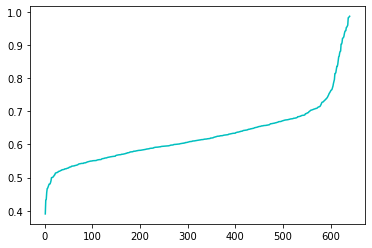

In [96]:
X = range(1, len(list(distance_dict.keys())) + 1) # 기준 인물 사진을 제외한 나머지 사진들의 닮은꼴 순위
Y = list(distance_dict.values()) # 닮은 정도를 0 ~ 1 범위로 표현한 값

plt.plot(X, Y, c = "c")
plt.show()

### 회고
   
**목표**   
   
1. 닮은꼴 인물 상위 5명을 벡터 거리차가 0.5 이내로 찾아낸다.
   
**새로 알게된 점**

1. 파일에서 얼굴을 추출하는 것이 불가능한 파일들을 사전에 걸러줘야 함.   
2. pillow_image을 save() 메소드로 저장할 때, 파일명에 확장자가 포함되어있거나 save(파일명, 확장자)와 같이 별도로 전달하지 않으면, 오류가 발생한다.    
3. 임베딩은 고차원 정보를 저차원으로 축소해 벡터화하는 과정이다.   

   
**궁금한 점**   

1. 임베딩 과정에선 정확히 어떤 정보를 추출해서 차원을 축소하고 벡터화하는지 궁금해졌다.

**과정 및 느낀 점**
   
- face_recognition 라이브러리를 사용해 사진에서 인물의 얼굴을 추출하고, 임베딩으로 벡터화 해 상위 5명을 출력했다. 어떤 기준으로 벡터를 추출하는지 알 수 없어 답답한 감이 있지만, 닮은꼴 상위 3명까지만 보면 모두 안경을 쓰고있기 때문에, "안경"이라는 특징을 추출한 것으로 추측할 수 있다.   
   
- 김범수님 사진 2장을 비교하는 부분에서 가능한 비슷한 사진을 구해서 비교했더니 유사도를 나타내는 벡터 거리가 0.297정도가 나왔다. 가장 닮은 인물로 나온 박찬환님과의 벡터 거리는 0.390이었고, 이는 노드에서 예시로 주어진 동일한 인물 사진 두 장의 벡터 거리인 0.347과 크게 차이나지 않는다. 이를 고려하면서 김범수님과 박찬환님의 사진을 보면, 더 헷갈린다. 눈매도 다르고 눈썹의 길이와 짙은 정도도 다르며 짓고있는 표정과 얼굴이 향한 방향도 조금 다른데, 단지 안경 하나 때문에 높게 나온 것인지 궁금하다. 게다가 이종석님부터는 안경도 쓰지 않았고 얼굴 형도 크게 다르다. 하지만 안경을 쓴 김성균님과 크게 차이나지 않는다.